# **EDA and Feature Preprocessing for House Price & Overall Quality Prediction**

## **1. Project Overview**

### Context

Accurately predicting house prices and overall quality requires selecting the most relevant features while removing noisy, redundant, or weak predictors. Feature selection improves model performance, interpretability, and reduced computational cost.

### Objectives

- Identify the most relevant features for predicting house prices and overall quality.
- Analyze feature importance using correlation analysis, Spearman's rank-order correlation, ANOVA, and mutual information.
- Determine which factors most influence home value and overall quality ratings.
- Improve model interpretability and reduce overfitting.
- Gain deeper insights into the key characteristics that define a home's desirability.

Accurately predicting house prices and overall quality requires selecting the most relevant features while removing noisy, redundant, or weak predictors. Feature selection will improve model performance and interpretability.

## **2. Import Libraries & Load Data**

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import f_oneway
from scipy.stats import spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [53]:
ames_df = pd.read_csv('../data/clean_data/ames.csv')

In [54]:
# Separate numerical and categorical columns
numerical_cols = ames_df.select_dtypes(include=['number']).columns
categorical_cols = ames_df.select_dtypes(exclude=['number']).columns

In [55]:
len(categorical_cols)

42

In [56]:
ames_df[categorical_cols].isna().sum()

ms_zoning         0
street            0
alley             0
lot_shape         0
land_contour      0
utilities         0
lot_config        0
land_slope        0
neighborhood      0
condition_1       0
condition_2       0
bldg_type         0
house_style       0
roof_style        0
roof_matl         0
exterior_1st      0
exterior_2nd      0
mas_vnr_type      0
exter_qual        0
exter_cond        0
foundation        0
bsmt_qual         0
bsmt_cond         0
bsmt_exposure     0
bsmtfin_type_1    0
bsmtfin_type_2    0
heating           0
heating_qc        0
central_air       0
electrical        0
kitchen_qual      0
functional        0
fireplace_qu      0
garage_type       0
garage_finish     0
garage_qual       0
garage_cond       0
paved_drive       0
pool_qc           0
fence             0
misc_feature      0
sale_type         0
dtype: int64

## **3. Identifying Feature Types**

When analyzing feature importance, it's crucial to differentiate between numerical and categorical features because different statistical techniques apply to each type. Treating all features the same way can lead to misleading conclusions.

In [57]:
print(f'Numerical Features: {len(ames_df.select_dtypes(include=['number']).columns.tolist())}\nCategorical Features: {len(ames_df.select_dtypes(exclude=['number']).columns.tolist())}')

Numerical Features: 39
Categorical Features: 42


### 3.1 Numerical Features

Not all numerical features behave the same way. To apply the correct correlation method, we need to distinguish:
- **Continuous** variables (e.g., house price, temperature) → can take any value in a range.
- **Discrete** variables (e.g., number of rooms, year built) → take only distinct, countable values.

When measuring correlation with the target:
- **Pearson correlation** is best for continuous variables with a linear relationship.
- **Spearman correlation** is preferred for discrete variables or when the relationship is monotonic but not necessarily linear.

In [58]:
numerical_features = ames_df.select_dtypes(include=['number'])
numerical_features = numerical_features.drop(columns=['id', 'pid', 'overall_qual', 'overall_cond', 'sale_price', 'ms_subclass']).columns.tolist()
print(numerical_features)

['lot_frontage', 'lot_area', 'year_built', 'year_remod_add', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'first_flr_sf', 'second_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 'garage_yr_blt', 'garage_cars', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', 'three_ssn_porch', 'screen_porch', 'pool_area', 'misc_val', 'mo_sold', 'yr_sold']


In [59]:
len(numerical_features)

33

In [60]:
discrete_features =  ['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
                      'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 'garage_cars', 'year_built', 
                      'year_remod_add', 'garage_yr_blt','mo_sold', 'yr_sold']

In [61]:
continuous_features = ['lot_frontage', 'lot_area', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2',
                       'bsmt_unf_sf', 'total_bsmt_sf', 'first_flr_sf', 'second_flr_sf', 'low_qual_fin_sf', 'gr_liv_area',
                       'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', 'three_ssn_porch',
                       'screen_porch', 'pool_area', 'misc_val']

In [62]:
len(discrete_features) + len(continuous_features)

33

### 3.2 Categorical Features

Categorical features represent non-numeric values, but some have inherent orderings. Thus, we split them into:
- **Nominal** variables (e.g., neighborhood, house style) → No meaningful order.
- **Ordinal** variables (e.g., quality ratings: Poor, Fair, Good, Excellent) → Have a meaningful order.

To analyze feature importance:

- **Ordinal** variables are encoded with Ordinal Encoding (mapping categories to meaningful numbers) and then tested using Spearman correlation with the target.
- **Nominal** variables are tested using ANOVA (Analysis of Variance), which checks whether different groups have significantly different mean values for the target variable.

In [63]:
# ms_subclass should be categorical:
ames_df['ms_subclass'] = ames_df['ms_subclass'].astype(str)

In [64]:
categorical_features = ames_df.select_dtypes(exclude=['number']).columns.tolist()
print(categorical_features)

['ms_subclass', 'ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc', 'central_air', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'misc_feature', 'sale_type']


In [65]:
len(categorical_features)

43

In [66]:
nominal_features = ['ms_subclass', 'ms_zoning', 'street', 'alley', 'lot_config', 'neighborhood', 
                    'condition_1', 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
                    'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'foundation', 'heating', 'central_air',
                    'garage_type', 'misc_feature', 'sale_type']

In [67]:
ordinal_features = ['lot_shape', 'land_slope', 'utilities', 'land_contour', 'exter_qual', 'exter_cond', 'bsmt_qual',
                    'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating_qc', 'electrical', 'kitchen_qual',
                    'functional', 'fireplace_qu', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence',
                   'overall_qual', 'overall_cond']

In [68]:
len(nominal_features) + len(ordinal_features) - 2 #'overall_qual', 'overall_cond'

43

#### Encoding Ordinal Features

In [69]:
ordinal_categories = {
    'lot_shape': ['IR3', 'IR2', 'IR1', 'Reg'],  # Regular is best
    'land_slope': ['Sev', 'Mod', 'Gtl'],  # Gentle slope is best
    'utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],  # All utilities is best
    'land_contour': ['Low', 'HLS', 'Bnk', 'Lvl'],  # Level is best
    'exter_qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Exterior quality
    'exter_cond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Exterior condition
    'bsmt_qual': ['Not Applicable', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Basement quality
    'bsmt_cond': ['Not Applicable', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Basement condition
    'bsmt_exposure': ['Not Applicable', 'No', 'Mn', 'Av', 'Gd'],  # Basement exposure
    'bsmtfin_type_1': ['Not Applicable', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Finished basement 1
    'bsmtfin_type_2': ['Not Applicable', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Finished basement 2
    'heating_qc': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Heating quality
    'electrical': ['Not Applicable', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],  # Electrical system
    'kitchen_qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Kitchen quality
    'functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # Home functionality
    'fireplace_qu': ['Not Applicable', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Fireplace quality
    'garage_finish': ['Not Applicable', 'Unf', 'RFn', 'Fin'],  # Garage finish
    'garage_qual': ['Not Applicable', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage quality
    'garage_cond': ['Not Applicable', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage condition
    'paved_drive': ['N', 'P', 'Y'],  # Paved driveway
    'pool_qc': ['Not Applicable', 'Fa', 'TA', 'Gd', 'Ex'],  # Pool quality
    'fence': ['Not Applicable', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],  # Fence quality
}

In [70]:
# Ordinal features that need encoding
ordinal_to_encode = [feature for feature in ordinal_features if feature not in ["overall_qual", "overall_cond"]]

# Create an OrdinalEncoder with predefined categories
encoder = OrdinalEncoder(categories=[ordinal_categories[feature] for feature in ordinal_to_encode], dtype=int)

# Apply encoding to ordinal features
ames_df[ordinal_to_encode] = encoder.fit_transform(ames_df[ordinal_to_encode])

In [71]:
ames_df[ordinal_features].head()

,lot_shape,land_slope,utilities,land_contour,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,...,functional,fireplace_qu,garage_finish,garage_qual,garage_cond,paved_drive,pool_qc,fence,overall_qual,overall_cond
0,2,2,3,3,3,2,3,3,1,6,...,7,0,2,3,3,2,0,0,6,8
1,2,2,3,3,3,2,4,3,1,6,...,7,3,2,3,3,2,0,0,7,5
2,3,2,3,3,2,3,3,3,1,6,...,7,0,1,3,3,2,0,0,5,7
3,3,2,3,3,2,2,4,3,1,1,...,7,0,3,3,3,2,0,0,5,5
4,2,2,3,3,2,2,2,4,1,1,...,7,0,1,3,3,0,0,0,6,8


## **4. Feature Importance Analysis for Overall Quality**

To build a reliable classification model for `overall quality`, it’s essential to identify the most relevant categorical predictors. Since `overall quality` is an ordinal variable, our focus will be on selecting categorical features—both ordinal and nominal—that have a significant impact on it.

To achieve this, we will:

- Analyze ordinal features by encoding them and using Spearman correlation, which measures the strength of monotonic relationships. This helps us determine whether higher or lower categories in each feature are associated with higher or lower Overall Quality scores.
- Analyze nominal features using ANOVA (Analysis of Variance) to assess whether differences in categorical groups significantly impact Overall Quality.

### 4.1 Ordinal Features

Spearman's rank correlation measures the monotonic relationship between two variables. Unlike Pearson correlation, which assumes a linear relationship, Spearman assesses whether an increase in one variable generally corresponds to an increase (or decrease) in another, even if the relationship is not strictly linear.

In [72]:
ordinal_ft_candidates = ['lot_shape', 'land_slope', 'utilities', 'land_contour', 'exter_qual', 'exter_cond', 'bsmt_qual',
                    'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating_qc', 'electrical', 'kitchen_qual',
                    'functional', 'fireplace_qu', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'pool_qc', 'fence']

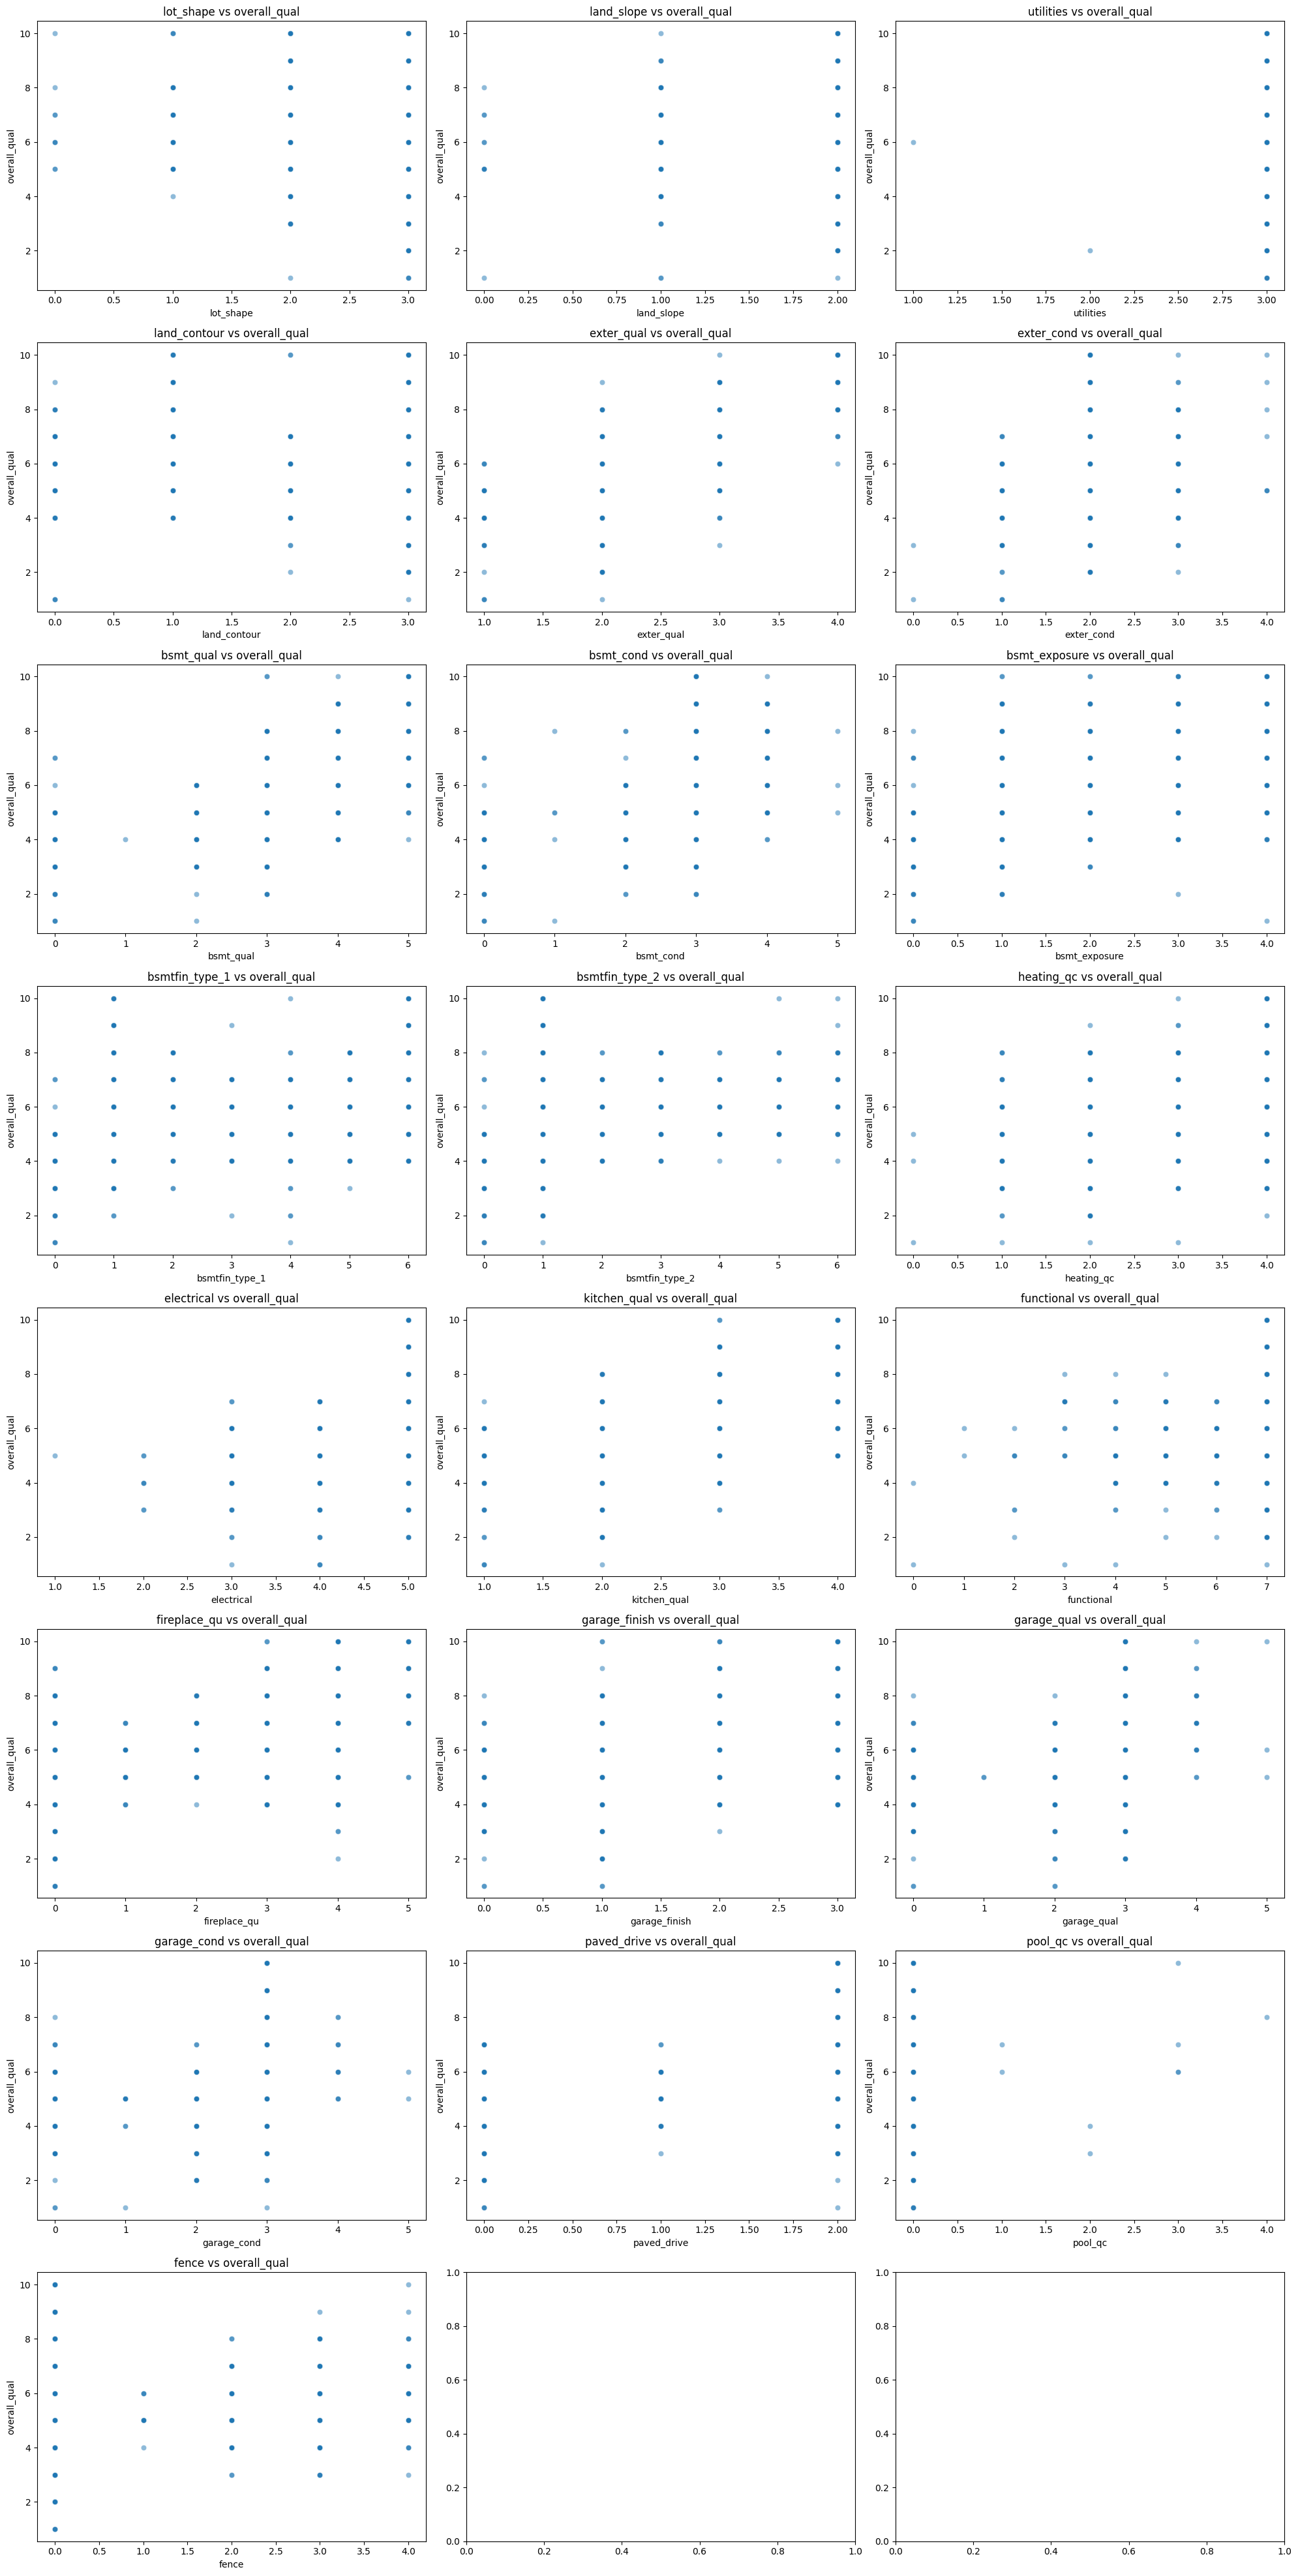

In [73]:
# Set figure size for multiple subplots
num_features = len(ordinal_ft_candidates)
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(20, num_features * 1.8))  # Adjust grid size

# Flatten axes array for easy iteration
axes = axes.flatten()

# Generate scatter plots for each ordinal feature
for i, feature in enumerate(ordinal_ft_candidates):
    sns.scatterplot(x=ames_df[feature], y=ames_df['overall_qual'], alpha=0.5, ax=axes[i])
    axes[i].set_title(f"{feature} vs overall_qual")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('overall_qual')

# Adjust layout
plt.tight_layout()
plt.show()

In [74]:
# Compute Spearman correlation for each ordinal feature with Overall_Qual
spearman_results = {feature: spearmanr(ames_df[feature], ames_df["overall_qual"]).correlation for feature in ordinal_ft_candidates}

# Convert results into a DataFrame
spearman_df = pd.DataFrame(spearman_results.items(), columns=['Feature', 'Spearman Correlation'])

# Sort by absolute correlation to see strongest relationships
spearman_df = spearman_df.sort_values(by="Spearman Correlation", ascending=False)

# Display spearman scores
spearman_df

,Feature,Spearman Correlation
4,exter_qual,0.728382
6,bsmt_qual,0.683459
13,kitchen_qual,0.678246
16,garage_finish,0.565222
11,heating_qc,0.488697
15,fireplace_qu,0.472501
8,bsmt_exposure,0.333842
9,bsmtfin_type_1,0.320639
17,garage_qual,0.308857
19,paved_drive,0.302184


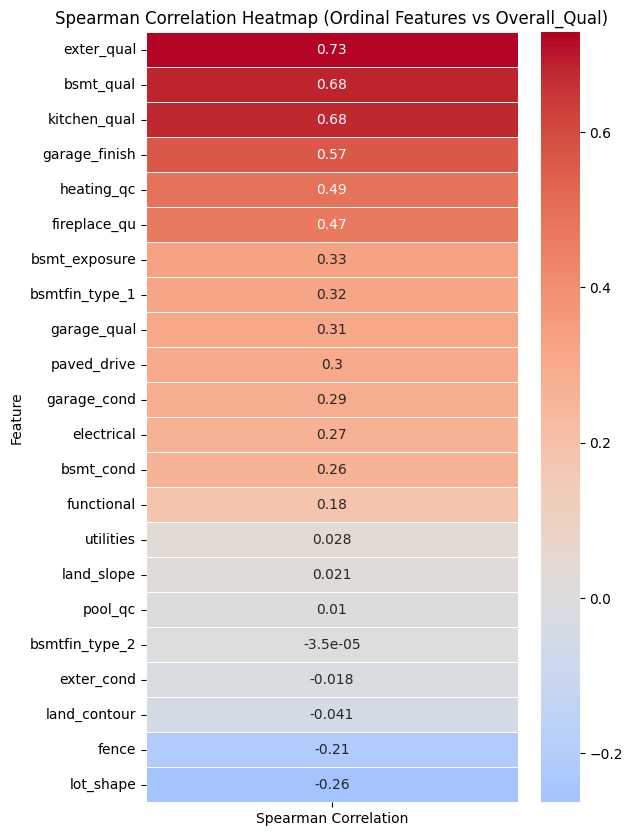

In [75]:
plt.figure(figsize=(6, 10))
sns.heatmap(spearman_df.set_index("Feature"), annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Spearman Correlation Heatmap (Ordinal Features vs Overall_Qual)")
plt.show()

#### Discarded Features

In [76]:
oq_ordinal_drop = ['utilities', 'land_slope', 'pool_qc', 'bsmtfin_type_2', 'exter_cond', 'land_contour']

### 4.2 Nominal Features

ANOVA (Analysis of Variance) is a statistical test used to determine if there are significant differences in means between groups within a categorical feature in relation to a numerical target variable.

For each nominal feature, ANOVA helps assess whether different categories have a statistically significant effect on `overall_qual`.

1. Define the Null Hypothesis
- The means of overall_qual are the same across all groups (i.e., the categorical feature has no impact).

2. Define the Alternative Hypothesis
- At least one group's mean is significantly different (i.e., the feature influences `overall_qual`).
  
3. Calculate the ANOVA F-statistic and p-value
- The **F-statistic** measures the variance between groups relative to variance within groups.
- The **p-value** tells us whether the observed differences are statistically significant.
  
4. Interpret the Results
- If **p-value < 0.05**, we reject the null hypothesis, and conclude that the feature has a significant effect on `overall_qual`.
- If **p-value ≥ 0.05**, we fail to reject the null hypothesis, meaning the feature likely does not have a significant effect on `overall_qual`.

In [77]:
nominal_ft_candidates = ['street', 'alley', 'lot_config', 'condition_1', 'condition_2',
                         'house_style', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
                         'foundation', 'heating', 'central_air', 'garage_type', 'misc_feature']

In [78]:
# Dictionary to store ANOVA results
anova_results = {}

# Perform ANOVA for each nominal feature
for feature in nominal_ft_candidates:
    # Group `Overall_Qual` by the categorical feature
    groups = [ames_df['overall_qual'][ames_df[feature] == category] for category in ames_df[feature].unique()]
    
    # Run ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    # Store results
    anova_results[feature] = {'F-Statistic': f_stat, 'p-value': p_value}

# Convert results into a DataFrame
anova_df = pd.DataFrame.from_dict(anova_results, orient='index').reset_index()
anova_df.rename(columns={'index': 'Feature'}, inplace=True)

# Sort by significance (p-value)
anova_df = anova_df.sort_values(by='p-value')

# Convert p-value column to True/False based on significance threshold
anova_df['Significant (p < 0.05)'] = anova_df['p-value'] < 0.05
anova_df = anova_df.drop(columns=['p-value'])
# Display results
anova_df.sort_values(by='F-Statistic', ascending=False)

,Feature,F-Statistic,Significant (p < 0.05)
11,foundation,209.096898,True
13,central_air,196.325284,True
10,mas_vnr_type,162.815053,True
14,garage_type,112.773385,True
8,exterior_1st,37.029239,True
9,exterior_2nd,33.690024,True
1,alley,29.191663,True
5,house_style,28.704751,True
6,roof_style,16.039161,True
12,heating,10.032888,True


**Results:** All of these will be used for my classification model.

### 4.3 Feature Selection

In [79]:
# Chosen features
classification_selected_features = ['street', 'alley', 'lot_config', 'condition_1', 'condition_2',
                         'house_style', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
                         'foundation', 'heating', 'central_air', 'garage_type', 'misc_feature', 'lot_shape',
                        'exter_qual', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'heating_qc',
                        'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_finish', 'garage_qual',
                        'garage_cond', 'paved_drive', 'fence', 'overall_qual']

## **5. Feature Importance Analysis for Sale Price**

To build an effective predictive model for `sale price`, we need to identify the features that have the most significant impact on home value. Understanding feature importance helps us select the most relevant predictors, improve model performance, and reduce noise from irrelevant variables.

In this section, we will analyze both numerical and categorical features to determine their relationship with `sale price` using appropriate statistical techniques:

### 5.1 Numerical Features

Numerical features can be analyzed using either Pearson or Spearman correlation, depending on their relationship with `sale_price`.

**Checking for Linearity**
- Compute Pearson correlation for all Numerical features.
- Generate scatter plots to visually inspect linearity.
- If the relationship is non-linear, we will use Spearman correlation instead of Pearson.

**Selection Criteria**

| Feature         | Pearson Correlation | Spearman Correlation | Interpretation |
|----------------|--------------------|----------------------|----------------|
| garage_cars    | High               | High                 | Strongly correlated both linearly and monotonically → Keep it |
| mo_sold        | Low               | High                 | Weak linear but strong monotonic relationship → Consider Spearman instead of Pearson |
| kitchen_abvgr  | Low               | Low                 | Weak in both → Consider removing it |

#### 5.1.a Discrete Features

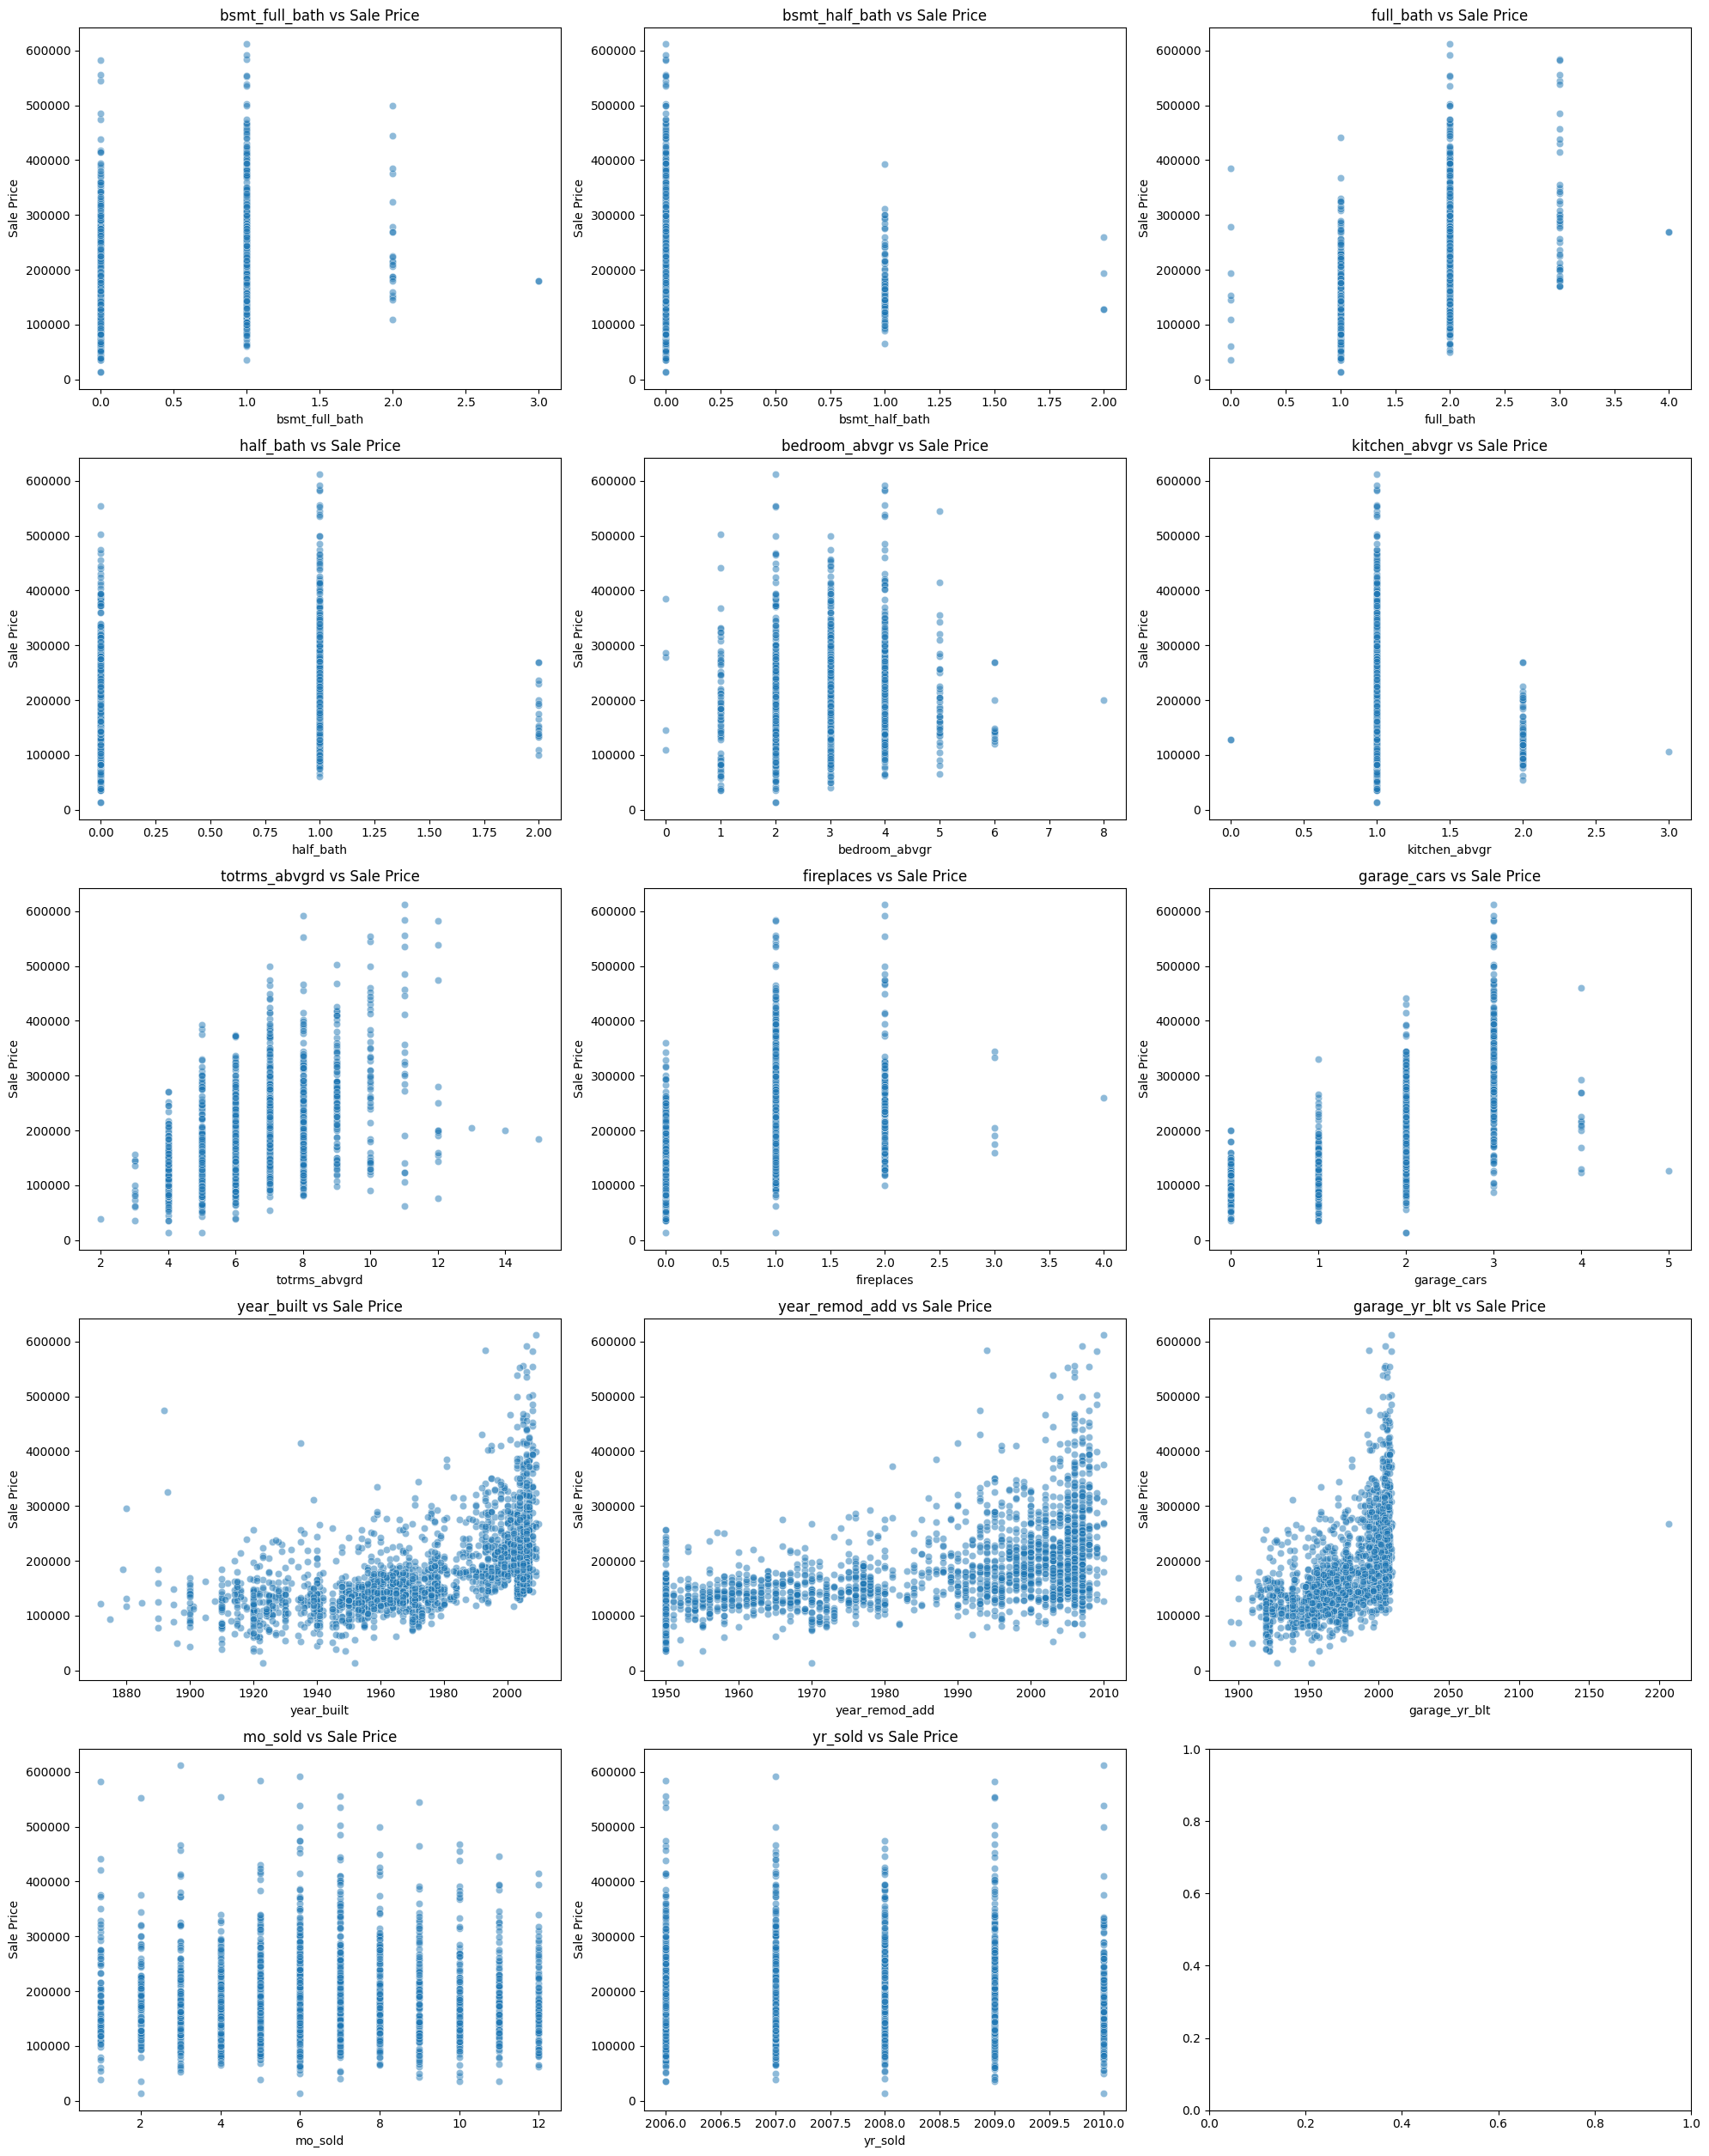

In [80]:
# Generate scatter plots to check for linearity
num_features = len(discrete_features)
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(20, num_features * 1.8))
axes = axes.flatten()

for i, feature in enumerate(discrete_features):
    sns.scatterplot(x=ames_df[feature], y=ames_df["sale_price"], alpha=0.5, ax=axes[i])
    axes[i].set_title(f"{feature} vs Sale Price")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Sale Price")

plt.tight_layout()
plt.show()

- **Remove row with garage_yr_blt > 2010** 

In [81]:
ames_df = ames_df[ames_df["garage_yr_blt"] <= 2010]
ames_df.shape

(2050, 81)

In [82]:
# Compute Pearson correlation for all discrete features with Sale Price
pearson_corr = ames_df[discrete_features + ['sale_price']].corr(method='pearson')['sale_price'].drop('sale_price')

# Convert to DataFrame
pearson_df = pd.DataFrame(pearson_corr).reset_index()
pearson_df.columns = ['Feature', 'Pearson Correlation']

# Sort by absolute correlation to see strongest relationships
pearson_df = pearson_df.sort_values(by="Pearson Correlation", ascending=False)

pearson_df

,Feature,Pearson Correlation
8,garage_cars,0.647825
9,year_built,0.571592
11,garage_yr_blt,0.559424
10,year_remod_add,0.550112
2,full_bath,0.537794
6,totrms_abvgrd,0.504316
7,fireplaces,0.470936
0,bsmt_full_bath,0.283892
3,half_bath,0.283511
4,bedroom_abvgr,0.137681


In [83]:
# Compute Spearman correlation for each discrete feature with Sale Price
spearman_results = {feature: spearmanr(ames_df[feature], ames_df["sale_price"]).correlation for feature in discrete_features}

# Convert results into a DataFrame
spearman_df = pd.DataFrame(spearman_results.items(), columns=['Feature', 'Spearman Correlation'])

# Sort by absolute correlation to see the strongest relationships
spearman_df = spearman_df.sort_values(by="Spearman Correlation", ascending=False)

spearman_df

,Feature,Spearman Correlation
8,garage_cars,0.700806
9,year_built,0.688284
11,garage_yr_blt,0.652420
2,full_bath,0.625233
10,year_remod_add,0.616772
7,fireplaces,0.525085
6,totrms_abvgrd,0.502477
3,half_bath,0.328472
0,bsmt_full_bath,0.273448
4,bedroom_abvgr,0.188309


In [84]:
# Merge Pearson and Spearman correlation DataFrames on the Feature column
combined_corr_df = pd.merge(pearson_df, spearman_df, on="Feature", how="inner")

# Rename columns for clarity
combined_corr_df.columns = ["Feature", "Pearson Correlation", "Spearman Correlation"]

# Sort by absolute Pearson or Spearman correlation to see the strongest relationships first
combined_corr_df = combined_corr_df.sort_values(by="Pearson Correlation", ascending=False)

combined_corr_df

,Feature,Pearson Correlation,Spearman Correlation
0,garage_cars,0.647825,0.700806
1,year_built,0.571592,0.688284
2,garage_yr_blt,0.559424,0.652420
3,year_remod_add,0.550112,0.616772
4,full_bath,0.537794,0.625233
5,totrms_abvgrd,0.504316,0.502477
6,fireplaces,0.470936,0.525085
7,bsmt_full_bath,0.283892,0.273448
8,half_bath,0.283511,0.328472
9,bedroom_abvgr,0.137681,0.188309


In [85]:
sp_discrete_drop = ['mo_sold', 'yr_sold', 'bsmt_half_bath', 'kitchen_abvgr']

#### 5.1.b Continous Features

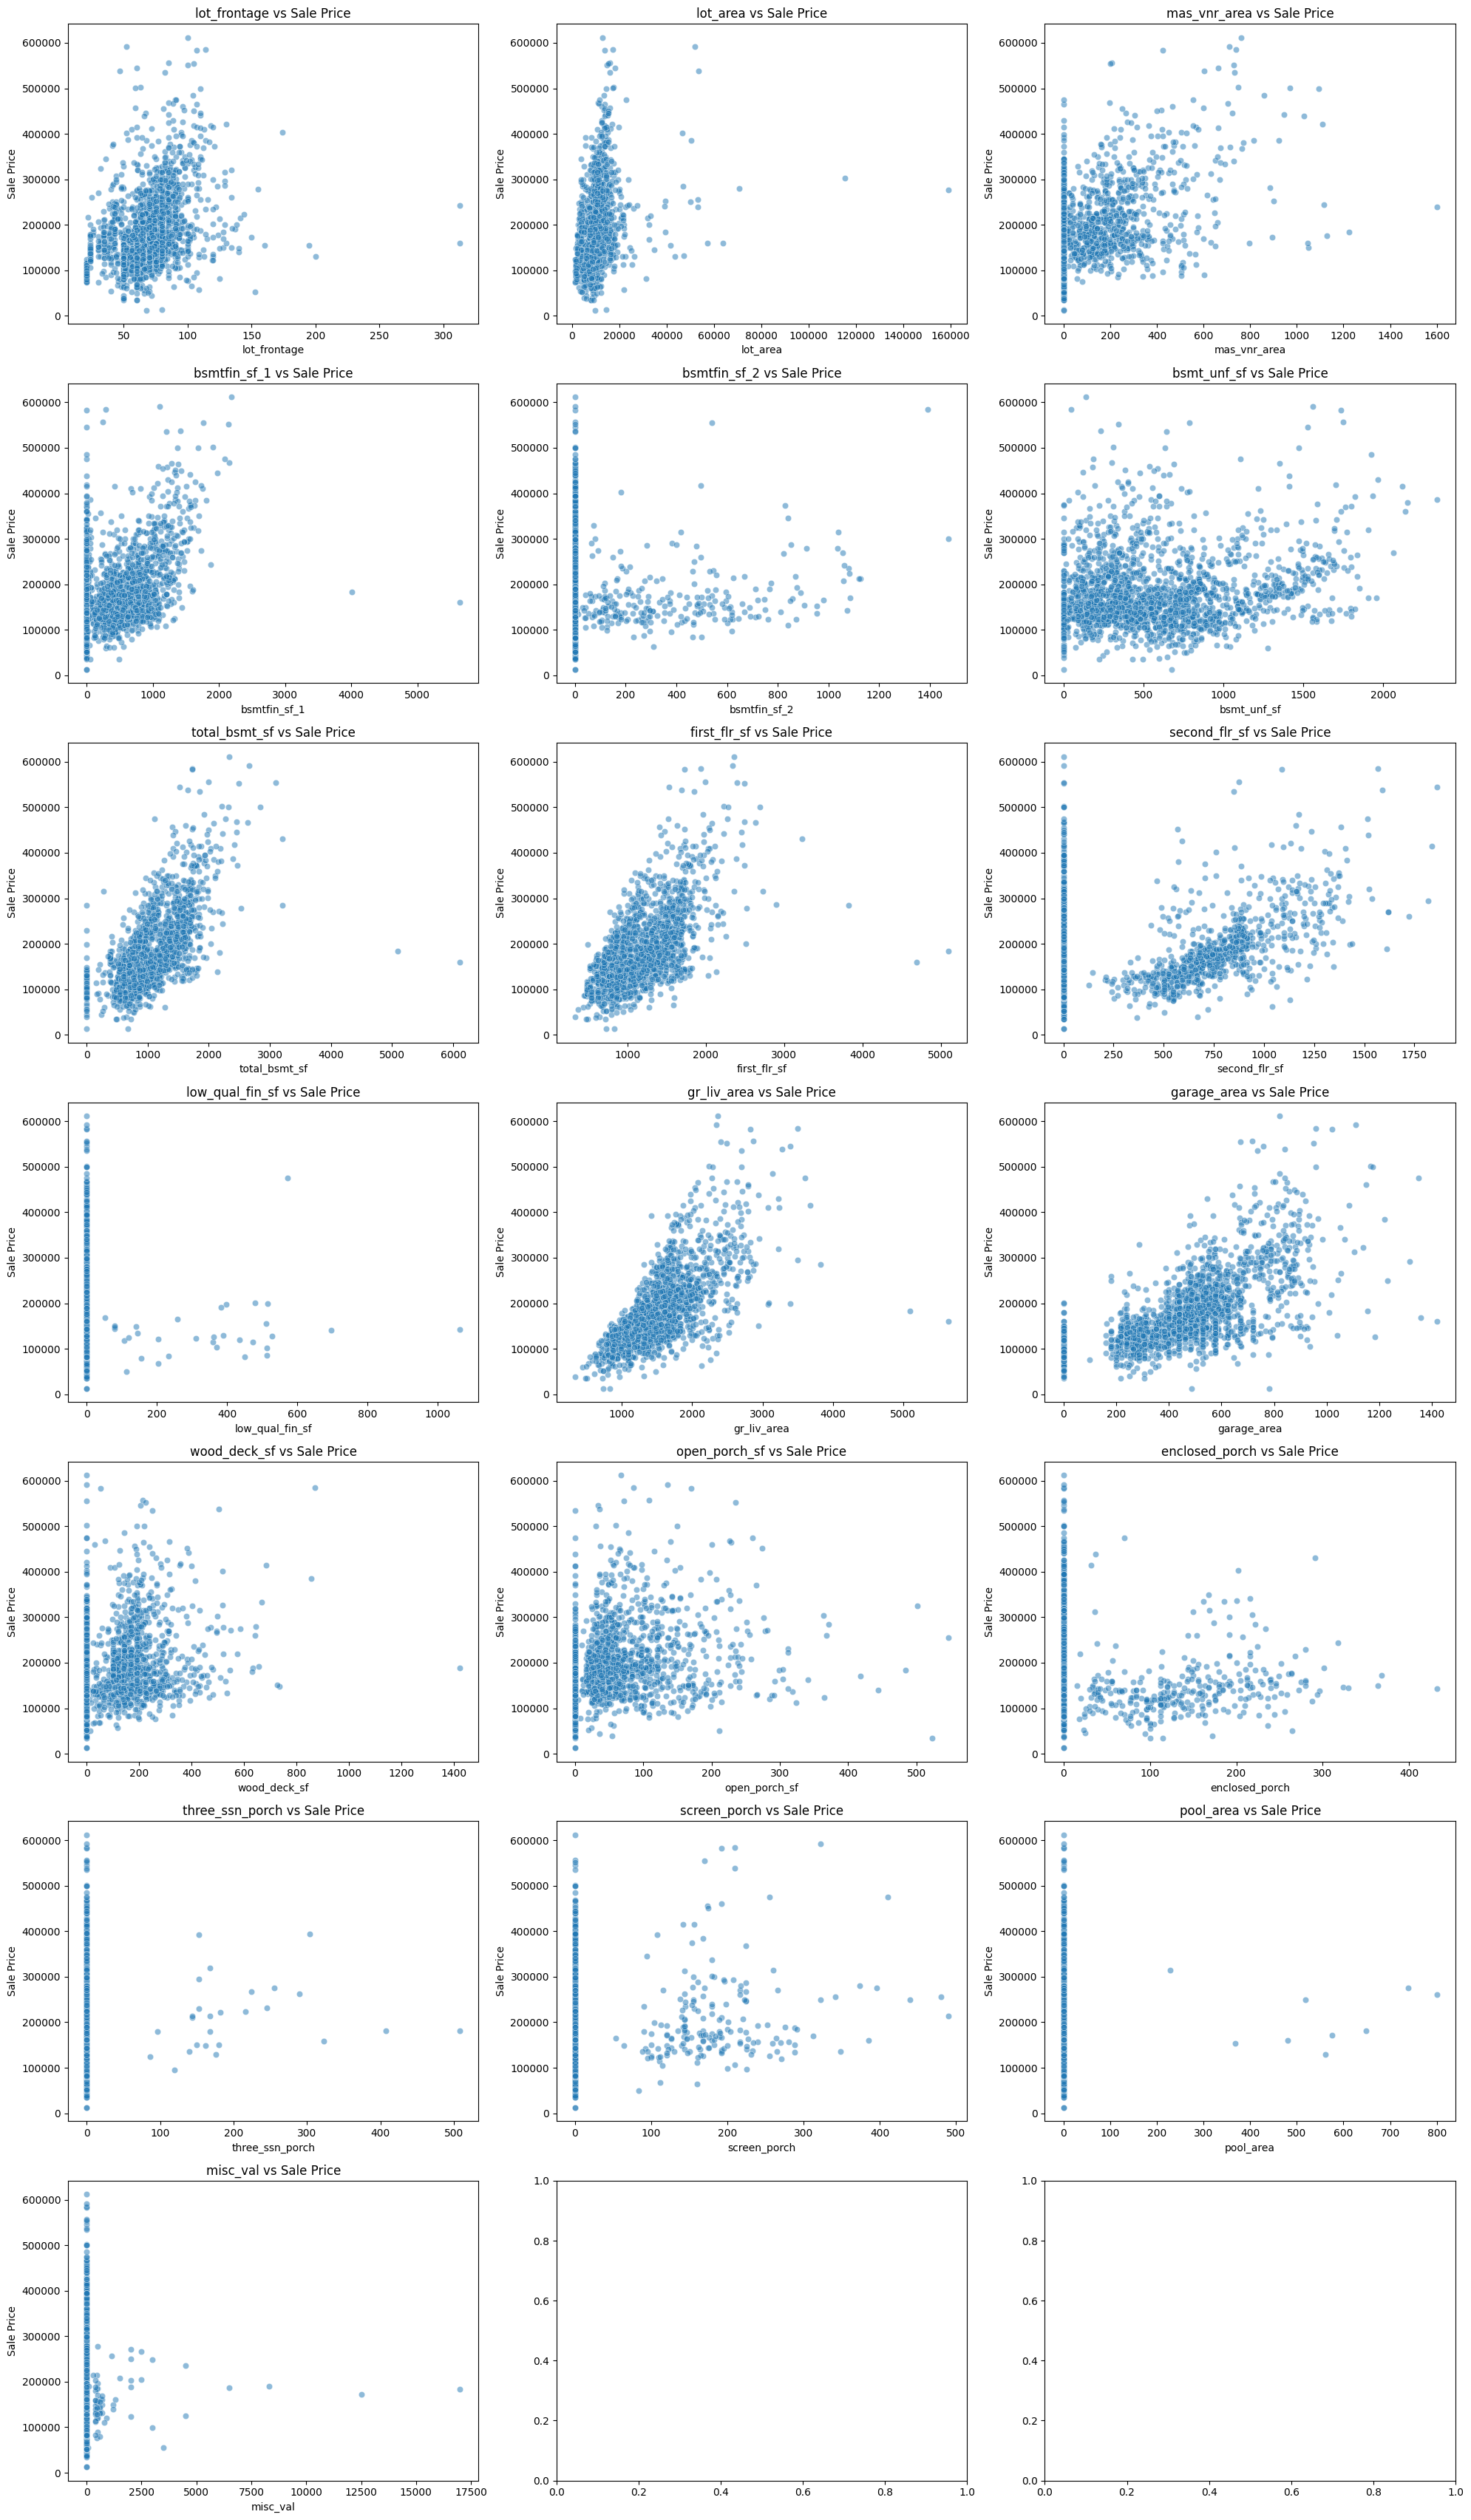

In [86]:
# Generate scatter plots to check for linearity
num_features = len(continuous_features)
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(20, num_features * 1.8))
axes = axes.flatten()

for i, feature in enumerate(continuous_features):
    sns.scatterplot(x=ames_df[feature], y=ames_df["sale_price"], alpha=0.5, ax=axes[i])
    axes[i].set_title(f"{feature} vs Sale Price")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Sale Price")

plt.tight_layout()
plt.show()

In [87]:
# Compute Pearson correlation for all continuous features with Sale Price
pearson_corr = ames_df[continuous_features + ['sale_price']].corr(method='pearson')['sale_price'].drop('sale_price')

# Convert to DataFrame
pearson_df = pd.DataFrame(pearson_corr).reset_index()
pearson_df.columns = ['Feature', 'Pearson Correlation']

# Sort by absolute correlation to see strongest relationships
pearson_df = pearson_df.sort_values(by="Pearson Correlation", ascending=False)

pearson_df

,Feature,Pearson Correlation
10,gr_liv_area,0.697173
11,garage_area,0.650016
6,total_bsmt_sf,0.629090
7,first_flr_sf,0.618284
2,mas_vnr_area,0.504061
3,bsmtfin_sf_1,0.423825
0,lot_frontage,0.338548
13,open_porch_sf,0.333990
12,wood_deck_sf,0.326433
1,lot_area,0.296794


In [88]:
# Compute Spearman correlation for each continuous feature with Sale Price
spearman_results = {feature: spearmanr(ames_df[feature], ames_df["sale_price"]).correlation for feature in continuous_features}

# Convert results into a DataFrame
spearman_df = pd.DataFrame(spearman_results.items(), columns=['Feature', 'Spearman Correlation'])

# Sort by absolute correlation to see the strongest relationships
spearman_df = spearman_df.sort_values(by="Spearman Correlation", ascending=False)

spearman_df

,Feature,Spearman Correlation
10,gr_liv_area,0.727113
11,garage_area,0.661048
6,total_bsmt_sf,0.616871
7,first_flr_sf,0.590736
13,open_porch_sf,0.486177
2,mas_vnr_area,0.444902
1,lot_area,0.431357
0,lot_frontage,0.395195
12,wood_deck_sf,0.363326
3,bsmtfin_sf_1,0.348483


In [89]:
# Merge Pearson and Spearman correlation DataFrames on the Feature column
combined_corr_df = pd.merge(pearson_df, spearman_df, on="Feature", how="inner")

# Rename columns for clarity
combined_corr_df.columns = ["Feature", "Pearson Correlation", "Spearman Correlation"]

# Sort by absolute Pearson or Spearman correlation to see the strongest relationships first
combined_corr_df = combined_corr_df.sort_values(by="Pearson Correlation", ascending=False)

combined_corr_df

,Feature,Pearson Correlation,Spearman Correlation
0,gr_liv_area,0.697173,0.727113
1,garage_area,0.650016,0.661048
2,total_bsmt_sf,0.629090,0.616871
3,first_flr_sf,0.618284,0.590736
4,mas_vnr_area,0.504061,0.444902
5,bsmtfin_sf_1,0.423825,0.348483
6,lot_frontage,0.338548,0.395195
7,open_porch_sf,0.333990,0.486177
8,wood_deck_sf,0.326433,0.363326
9,lot_area,0.296794,0.431357


In [90]:
sp_continous_drop = ['three_ssn_porch', 'pool_area', 'bsmtfin_sf_2', 'misc_val', 'low_qual_fin_sf']

#### 5.1.c Feature Selection

In [91]:
numerical_drop = sp_continous_drop + sp_discrete_drop
print(numerical_drop)

['three_ssn_porch', 'pool_area', 'bsmtfin_sf_2', 'misc_val', 'low_qual_fin_sf', 'mo_sold', 'yr_sold', 'bsmt_half_bath', 'kitchen_abvgr']


### 5.2 Categorical Features

Categorical variables describe qualitative aspects such as the type of exterior material, the style of the house, or the presence of certain amenities. </br>
To properly assess their influence on Sale Price, they will be analyzed using:
- Spearman correlation for ordinal features, as their ordered values allow ranking-based correlation.
- ANOVA (Analysis of Variance) for nominal features, to determine if differences in categories significantly impact Sale Price.

#### 5.2.a Ordinal Features

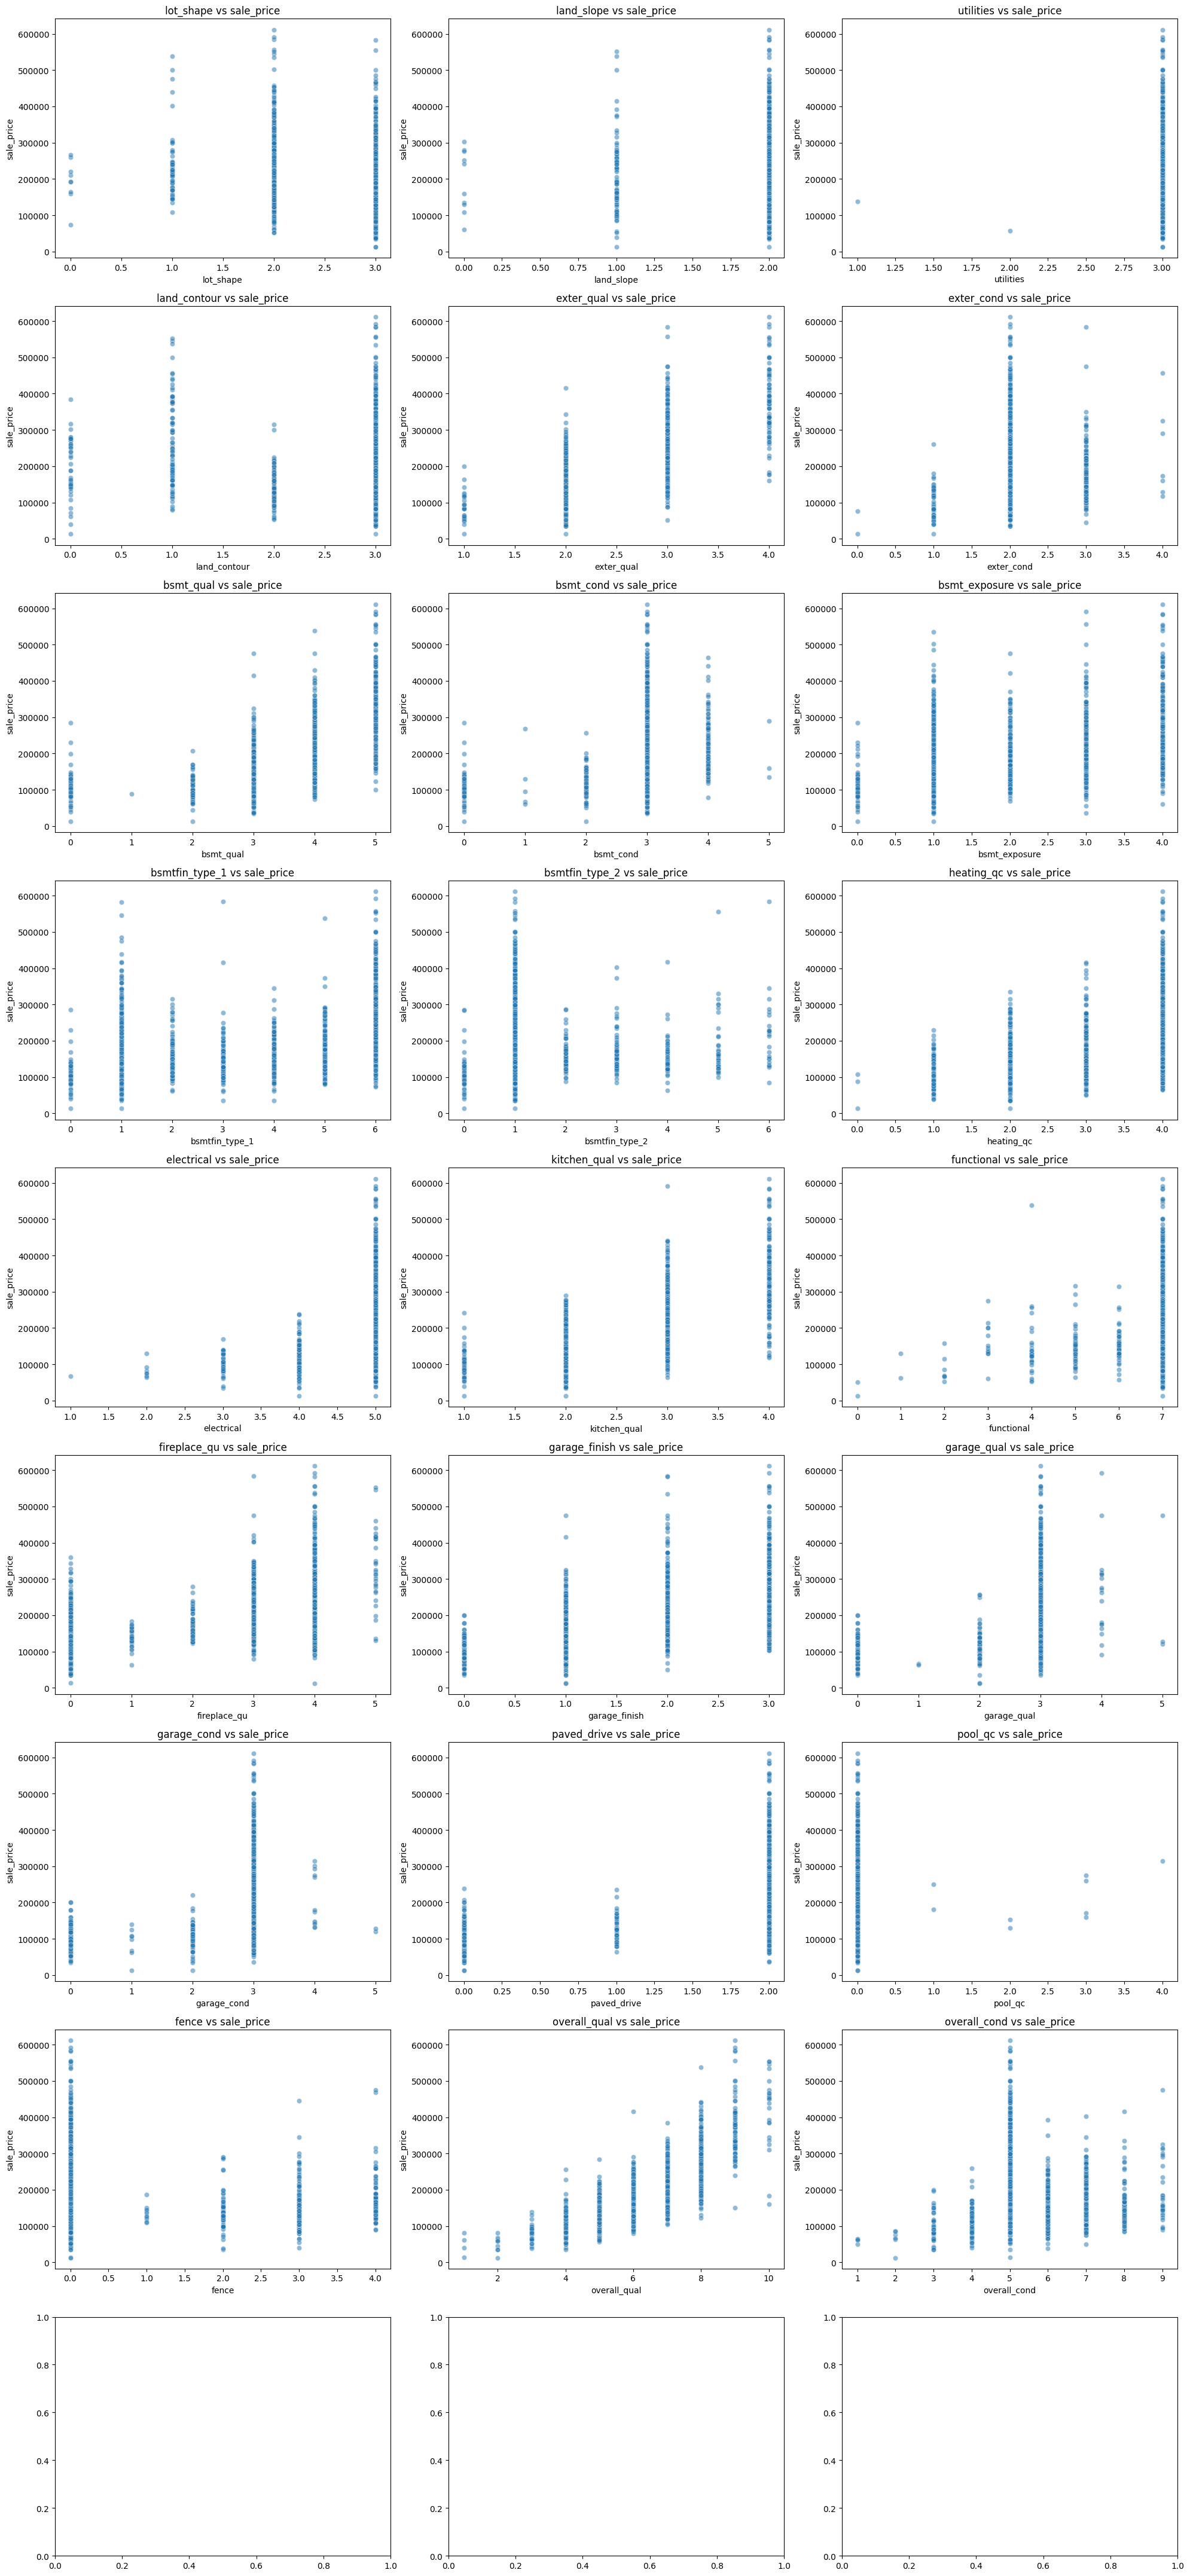

In [92]:
# Set figure size for multiple subplots
num_features = len(ordinal_features)
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(20, num_features * 1.8))  # Adjust grid size

# Flatten axes array for easy iteration
axes = axes.flatten()

# Generate scatter plots for each ordinal feature
for i, feature in enumerate(ordinal_features):
    sns.scatterplot(x=ames_df[feature], y=ames_df['sale_price'], alpha=0.5, ax=axes[i])
    axes[i].set_title(f"{feature} vs sale_price")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('sale_price')

# Adjust layout
plt.tight_layout()
plt.show()

In [93]:
# Compute Spearman correlation for each ordinal feature with Overall_Qual
spearman_results = {feature: spearmanr(ames_df[feature], ames_df['sale_price']).correlation for feature in ordinal_features}

# Convert results into a DataFrame
spearman_df = pd.DataFrame(spearman_results.items(), columns=['Feature', 'Spearman Correlation'])

# Sort by absolute correlation to see strongest relationships
spearman_df = spearman_df.sort_values(by='Spearman Correlation', ascending=False)

# Display spearman scores
spearman_df

,Feature,Spearman Correlation
22,overall_qual,0.806701
6,bsmt_qual,0.698173
4,exter_qual,0.696438
13,kitchen_qual,0.684114
16,garage_finish,0.634764
15,fireplace_qu,0.542785
11,heating_qc,0.518506
9,bsmtfin_type_1,0.413526
8,bsmt_exposure,0.383298
17,garage_qual,0.368144


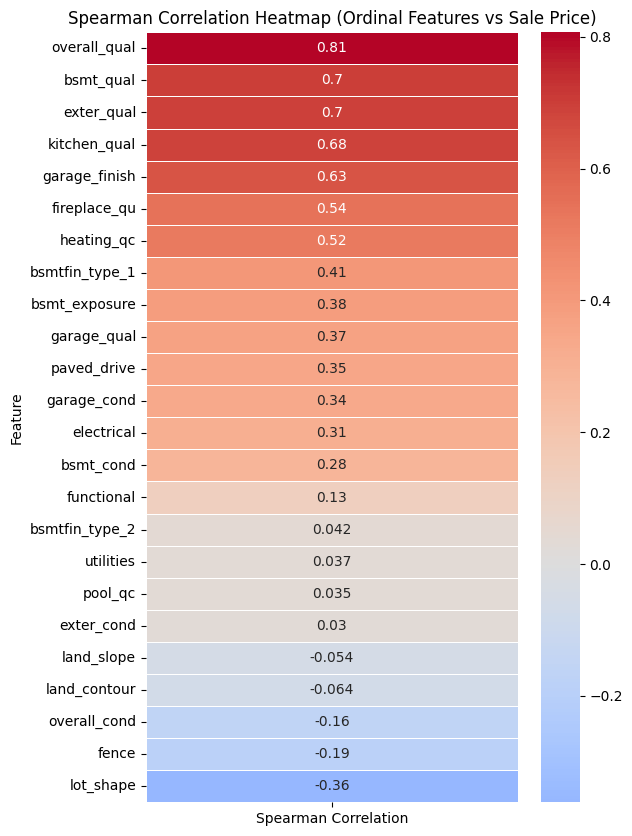

In [94]:
plt.figure(figsize=(6, 10))
sns.heatmap(spearman_df.set_index("Feature"), annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Spearman Correlation Heatmap (Ordinal Features vs Sale Price)")
plt.show()

In [95]:
sp_ordinal_drop = ['bsmtfin_type_2', 'utilities', 'pool_qc',
                   'exter_cond', 'land_slope', 'land_contour']

#### 5.2.b Nominal Features

In [96]:
# Dictionary to store ANOVA results
anova_results = {}

# Perform ANOVA for each nominal feature
for feature in nominal_features:
    # Group `sale_price` by the categorical feature
    groups = [ames_df['sale_price'][ames_df[feature] == category] for category in ames_df[feature].unique()]
    
    # Run ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    # Store results
    anova_results[feature] = {'F-Statistic': f_stat, 'p-value': p_value}

# Convert results into a DataFrame
anova_df = pd.DataFrame.from_dict(anova_results, orient='index').reset_index()
anova_df.rename(columns={'index': 'Feature'}, inplace=True)

# Sort by significance (p-value)
anova_df = anova_df.sort_values(by='p-value')

# Convert p-value column to True/False based on significance threshold
anova_df['Significant (p < 0.05)'] = anova_df['p-value'] < 0.05
anova_df = anova_df.drop(columns=['p-value'])
# Display results
anova_df.sort_values(by='F-Statistic', ascending=False)

,Feature,F-Statistic,Significant (p < 0.05)
14,mas_vnr_type,173.789875,True
17,central_air,170.624683,True
15,foundation,165.459270,True
18,garage_type,118.537011,True
5,neighborhood,102.742078,True
0,ms_subclass,46.832467,True
1,ms_zoning,42.420239,True
20,sale_type,42.306000,True
12,exterior_1st,34.511668,True
10,roof_style,31.672483,True


In [97]:
sp_nominal_drop = ['misc_feature']

#### 5.2.c Feature Selection

In [98]:
categorical_drop = sp_nominal_drop + sp_ordinal_drop
print(categorical_drop)

['misc_feature', 'bsmtfin_type_2', 'utilities', 'pool_qc', 'exter_cond', 'land_slope', 'land_contour']


## **6. Feature Preprocessing**

In [99]:
# Selected features to predict overal quality
oq_selected_features = ames_df[classification_selected_features]

# Encode Nominal Features
oq_selected_nominal = oq_selected_features.select_dtypes(exclude=['number']).columns
oq_selected_features = pd.get_dummies(oq_selected_features, columns=oq_selected_nominal, drop_first=True, dtype=int)

# To CSV
oq_selected_features.to_csv('../data/logistic_regression_model_data/processed_data/feature_data.csv', index=False)

In [100]:
# Selected features to predict sale price
sp_selected_features = ames_df.drop(columns=numerical_drop)
sp_selected_features = sp_selected_features.drop(columns=categorical_drop)


#Encode Nominal Features
sp_selected_nominal = sp_selected_features.select_dtypes(exclude=['number']).columns
sp_selected_features = pd.get_dummies(sp_selected_features, columns=sp_selected_nominal, drop_first=True, dtype=int)

# To CSV
sp_selected_features.to_csv('../data/linear_regression_model_data/processed_data/feature_data.csv', index=False)